In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import glob
import json
import os
import sys
import statsmodels.api as st
from statsmodels.discrete.discrete_model import MNLogit
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
sys.path.append("/home/stacy/GitHub/SynRD/papers/marijuana19fairman/helpers")
sys.path.append("/home/stacy/GitHub/private-pgm/")
# sys.path.insert(1, "/home/stacy/GitHub/private-pgm/src")
from host_mst_wrapper.mst.mst import MSTSynthesizer
from host_mst_wrapper.mst.pmse import pmse_ratio
from helpers import plot_figure, get_encoded_df, get_unencoded_df, load_data, get_aOR

# MST

In [3]:
df = load_data()
df.shape

(296467, 6)

In [4]:
df.dtypes

YEAR          int64
CLASS        object
SEX          object
RACE         object
AGE_GROUP    object
AGE           int64
dtype: object

In [5]:
df_enc = get_encoded_df(df)
df_enc.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,6,2,1,2,4,8
1,6,2,0,3,1,3
2,6,0,0,6,3,6
3,6,3,1,3,0,1
4,6,5,1,3,4,8


In [6]:
%%time
avg_pmse = 0
seeds = range(20)
for s in seeds:
    avg_pmse += pmse_ratio(df_enc, df_enc, seed=s)
print('Average pMSE:',round(avg_pmse/len(seeds),3))

Average pMSE: 1.03
CPU times: user 28.4 s, sys: 46 s, total: 1min 14s
Wall time: 10.4 s


In [7]:
df_domain = {
    "YEAR": 11,
    "CLASS": 6,
    "SEX": 2,
    "RACE": 7,
    "AGE_GROUP": 5,
    "AGE": 10,
}

domain_file_name = 'nsduh_processed_domain.json'
domain_file_path = os.path.join('../../data', domain_file_name)
with open(domain_file_path, 'w') as domain_file:
    json.dump(df_domain, domain_file)

In [9]:
%%time
cliques_to_try = [
    [],
    [('SEX', 'AGE_GROUP'), ('AGE_GROUP', 'RACE')],
    [('SEX', 'CLASS'), ('AGE_GROUP', 'CLASS'), ('RACE', 'CLASS')]
]

for cl in cliques_to_try:
    synth = MSTSynthesizer(epsilon=1.0, 
                        domain_path=domain_file_path,
                        custom_cliques=True,
                        cliques_set=cl)
    synth.fit(df_enc)
    mst_fake_data = synth.sample(samples=len(df_enc))
    avg_pmse = 0
    for s in seeds:
        avg_pmse += pmse_ratio(df_enc, mst_fake_data, seed=s)
    print('Average pMSE:',round(avg_pmse/len(seeds),3))
    print('')

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[]
Average pMSE: 1.099

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[('SEX', 'AGE_GROUP'), ('AGE_GROUP', 'RACE')]
Average pMSE: 1.188

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[('SEX', 'CLASS'), ('AGE_GROUP', 'CLASS'), ('RACE', 'CLASS')]
Average pMSE: 1.077

CPU times: user 2min 33s, sys: 2min 37s, total: 5min 11s
Wall time: 1min 38s


In [8]:
%%time
synth = MSTSynthesizer(epsilon=1.0, 
                        domain_path=domain_file_path)
synth.fit(df_enc)
mst_fake_data = synth.sample(samples=len(df_enc))

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5, AGE: 10)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP', 'AGE'], dtype='object')
[('YEAR', 'CLASS'), ('CLASS', 'AGE'), ('CLASS', 'RACE'), ('CLASS', 'SEX'), ('AGE_GROUP', 'AGE')]
CPU times: user 28.1 s, sys: 185 ms, total: 28.3 s
Wall time: 28.2 s


In [9]:
mst_fake_data.dtypes

YEAR         int64
CLASS        int64
SEX          int64
RACE         int64
AGE_GROUP    int64
AGE          int64
dtype: object

In [10]:
df_fake = get_unencoded_df(df, mst_fake_data)
df_fake['SEX'] = df_fake['SEX'].astype('category')
df_fake['RACE'] = df_fake['RACE'].astype('category')
df_fake['AGE_GROUP'] = df_fake['AGE_GROUP'].astype('category')
df_fake['CLASS'] = df_fake['CLASS'].astype('category')
df_fake['YEAR'] = df_fake['YEAR'].astype('category')
df_fake['AGE'] = df_fake['AGE'].astype('category')
df_fake.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2014,MARIJUANA,Male,White,18-19,18
1,2007,NO_DRUG_USE,Female,White,16-17,16
2,2009,ALCOHOL,Female,White,20-21,20
3,2008,NO_DRUG_USE,Male,White,14-15,14
4,2008,NO_DRUG_USE,Male,Black,18-19,18


In [12]:
df_fake.dtypes

YEAR         category
CLASS        category
SEX          category
RACE         category
AGE_GROUP    category
AGE          category
dtype: object

## Compare true and synthetic data

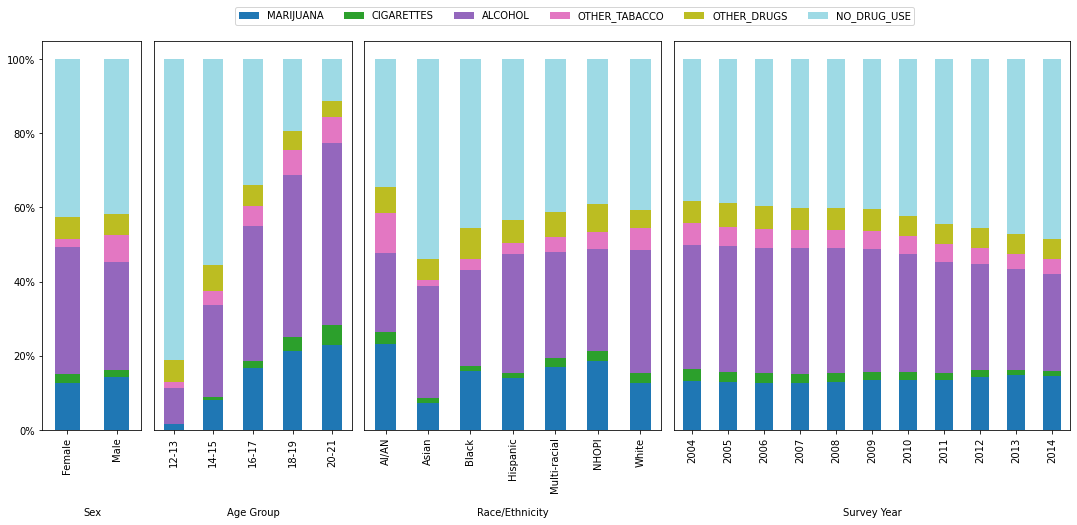

In [13]:
plot_figure(df)

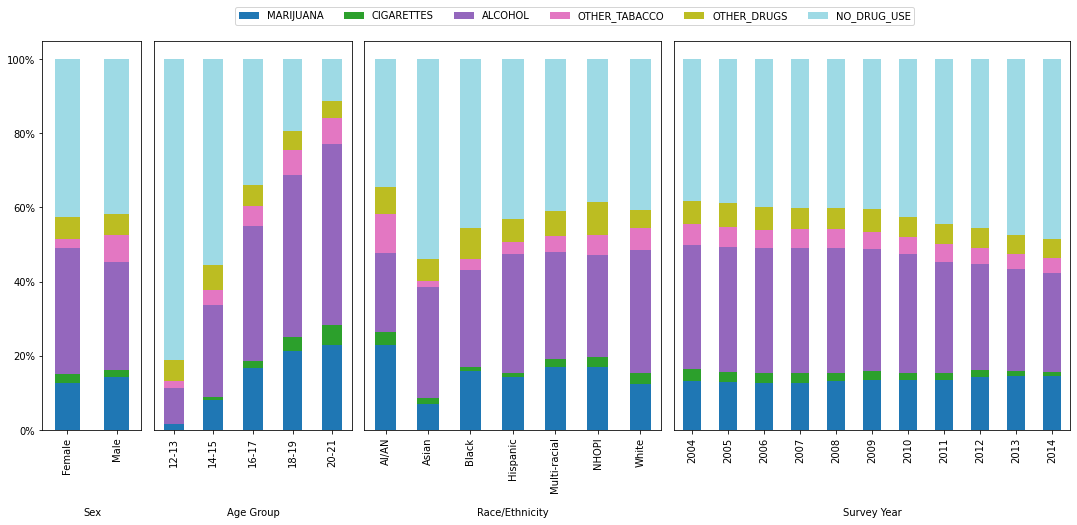

In [15]:
plot_figure(df_fake)

In [14]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2010,MARIJUANA,Male,Black,20-21,20
1,2010,MARIJUANA,Female,Hispanic,14-15,15
2,2010,ALCOHOL,Female,White,18-19,18
3,2010,NO_DRUG_USE,Male,Hispanic,12-13,13
4,2010,OTHER_TABACCO,Male,Hispanic,20-21,20


In [16]:
df_fake.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2014,MARIJUANA,Male,White,18-19,18
1,2007,NO_DRUG_USE,Female,White,16-17,16
2,2009,ALCOHOL,Female,White,20-21,20
3,2008,NO_DRUG_USE,Male,White,14-15,14
4,2008,NO_DRUG_USE,Male,Black,18-19,18


In [17]:
df.describe()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
count,296467,296467,296467,296467,296467,296467
unique,11,6,2,7,5,10
top,2011,NO_DRUG_USE,Male,White,16-17,16
freq,29121,125152,148945,175218,66936,33853


In [18]:
df_fake.describe()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
count,296467,296467,296467,296467,296467,296467
unique,11,6,2,7,5,10
top,2011,NO_DRUG_USE,Male,White,16-17,16
freq,29156,125143,148942,175211,66941,33862


In [19]:
def compare(df, df_fake, column_name):
    return pd.DataFrame([
            df[column_name].value_counts(),
            df_fake[column_name].value_counts(),
            df[column_name].value_counts() - df_fake[column_name].value_counts()
    ], index=['real', 'mst', 'diff'])

In [20]:
class_compare = compare(df, df_fake, 'CLASS')
class_compare

,NO_DRUG_USE,ALCOHOL,MARIJUANA,OTHER_DRUGS,OTHER_TABACCO,CIGARETTES
real,125152,93652,39914,16875,14320,6554
mst,125143,93634,39910,16898,14330,6552
diff,9,18,4,-23,-10,2


In [21]:
class_compare.sum(axis=1)

real    296467
mst     296467
diff         0
dtype: int64

# aOR

In [42]:
aOR = get_aOR(df)
aOR

Optimization terminated successfully.
         Current function value: 1.213960
         Iterations 8


,aOR,Lower CI,Higher CI,pvalue,aOR,Lower CI,Higher CI,pvalue,aOR,Lower CI,Higher CI,pvalue
Male vs. Female,1.334,1.303,1.366,0.0,1.476,1.399,1.556,0.000,1.241,1.211,1.273,0.000
White vs. AI/AN,0.341,0.313,0.373,0.0,0.634,0.532,0.756,0.000,0.399,0.365,0.436,0.000
White vs. Asian,1.676,1.544,1.820,0.0,0.787,0.651,0.950,0.013,3.345,3.075,3.638,0.000
White vs. Black,0.623,0.601,0.645,0.0,0.344,0.312,0.379,0.000,0.992,0.958,1.028,0.668
White vs. Hispanic,0.871,0.844,0.899,0.0,0.417,0.382,0.454,0.000,0.974,0.942,1.007,0.118
White vs. Multi-racial,0.626,0.591,0.663,0.0,0.707,0.622,0.804,0.000,0.617,0.581,0.655,0.000
White vs. NHOPI,0.580,0.495,0.679,0.0,0.663,0.471,0.935,0.019,0.733,0.622,0.865,0.000
AGE,0.932,0.927,0.936,0.0,1.146,1.133,1.160,0.000,0.580,0.577,0.583,0.000
YEAR,0.965,0.961,0.969,0.0,0.912,0.904,0.920,0.000,1.028,1.023,1.032,0.000


In [43]:
syn_aOR = get_aOR(df_fake)
syn_aOR

Optimization terminated successfully.
         Current function value: 1.217771
         Iterations 8


,aOR,Lower CI,Higher CI,pvalue,aOR,Lower CI,Higher CI,pvalue,aOR,Lower CI,Higher CI,pvalue
Male vs. Female,1.313,1.282,1.344,0.0,1.487,1.410,1.568,0.000,1.140,1.112,1.168,0.0
White vs. AI/AN,0.349,0.319,0.381,0.0,0.678,0.572,0.804,0.000,0.452,0.414,0.494,0.0
White vs. Asian,1.603,1.475,1.743,0.0,0.927,0.773,1.111,0.412,2.420,2.223,2.634,0.0
White vs. Black,0.615,0.594,0.636,0.0,0.333,0.302,0.367,0.000,0.887,0.856,0.919,0.0
White vs. Hispanic,0.845,0.819,0.872,0.0,0.403,0.370,0.439,0.000,0.935,0.904,0.966,0.0
White vs. Multi-racial,0.639,0.603,0.677,0.0,0.606,0.531,0.692,0.000,0.740,0.697,0.785,0.0
White vs. NHOPI,0.608,0.518,0.715,0.0,0.649,0.454,0.927,0.017,0.705,0.595,0.835,0.0
AGE,0.933,0.929,0.938,0.0,1.139,1.126,1.153,0.000,0.585,0.582,0.588,0.0
YEAR,0.963,0.960,0.967,0.0,0.912,0.904,0.920,0.000,1.010,1.006,1.014,0.0


--------------------